# TRPO 算法

教程链接：[TRPO 算法](https://hrl.boyuai.com/chapter/2/trpo%E7%AE%97%E6%B3%95)

策略梯度算法有一个明显的缺点：当策略网络是深度模型时，沿着策略梯度更新参数，很有可能由于步长太长，策略突然显著变差，进而影响训练效果。

针对以上问题，我们考虑在更新时找到一块信任区域（trust region），在这个区域上更新策略时能够得到某种策略性能的安全性保证，这就是信任区域策略优化（trust region policy optimization，TRPO）算法的主要思想。

In [1]:
import torch
from torch import nn
import numpy as np
import gym
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.distributions import Normal, Categorical, kl_divergence
import rl_utils
import copy
from typing import Tuple

## 1. 离散动作空间

In [2]:
# 定义定义策略网络和价值网络（与 Actor-Critic 算法一样）
class PolicyNet(nn.Module):
    """
    定义策略网络，其输入是某个状态，输出则是该状态下的动作概率分布
    """
    def __init__(self, state_dim:int, hidden_dim:int, action_dim:int):
        super().__init__()
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, action_dim)

    def forward(self, x:torch.Tensor) -> torch.Tensor:
        x = F.relu(self.fc1(x))
        return F.softmax(self.fc2(x), dim=1)


class ValueNet(nn.Module):
    """
    定义价值网络，其输入是某个状态，输出则是状态的价值。
    """
    def __init__(self, state_dim:int, hidden_dim:int):
        super().__init__()
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 1)

    def forward(self, x:torch.Tensor) -> torch.Tensor:
        x = F.relu(self.fc1(x))
        return self.fc2(x)

In [3]:
class TRPO(rl_utils.BasePolicy):
    """ TRPO算法 """
    def __init__(self, 
            hidden_dim:int, state_space:gym.Space, action_space:gym.Space, 
            lmbda:float, kl_constraint:float, alpha:float, critic_lr:float, gamma:float, 
            device:torch.device
        ):
        state_dim = state_space.shape[0]
        action_dim = action_space.n
        # 策略网络参数不需要优化器更新
        self.actor = PolicyNet(state_dim, hidden_dim, action_dim).to(device)
        self.critic = ValueNet(state_dim, hidden_dim).to(device)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=critic_lr)
        self.gamma = gamma
        self.lmbda = lmbda  # GAE参数
        self.kl_constraint = kl_constraint  # KL距离最大限制
        self.alpha = alpha  # 线性搜索参数
        self.device = device

    def take_action(self, state:np.ndarray) -> int:
        state = torch.tensor(np.array([state]), dtype=torch.float).to(self.device)
        probs = self.actor(state)
        action_dist = Categorical(probs)
        action = action_dist.sample()
        return action.item()

    def hessian_matrix_vector_product(self, 
            states:torch.Tensor, old_action_dists:Categorical, vector:torch.Tensor
        ) -> torch.Tensor:
        """计算黑塞矩阵和一个向量的乘积"""
        new_action_dists = Categorical(self.actor(states))
        # 计算平均KL距离
        kl = torch.mean(kl_divergence(old_action_dists, new_action_dists))  
        kl_grad = torch.autograd.grad(kl, self.actor.parameters(), create_graph=True)
        kl_grad_vector = torch.cat([grad.view(-1) for grad in kl_grad])
        # KL距离的梯度先和向量进行点积运算
        kl_grad_vector_product = torch.dot(kl_grad_vector, vector)
        grad2 = torch.autograd.grad(kl_grad_vector_product, self.actor.parameters())
        grad2_vector = torch.cat([grad.view(-1) for grad in grad2])
        return grad2_vector

    def conjugate_gradient(self, 
            grad:torch.Tensor, states:torch.Tensor, old_action_dists:Categorical
        ) -> torch.Tensor:
        """共轭梯度法求解方程"""
        x = torch.zeros_like(grad)
        r = grad.clone()
        p = grad.clone()
        rdotr = torch.dot(r, r)
        for i in range(10):  # 共轭梯度主循环
            Hp = self.hessian_matrix_vector_product(states, old_action_dists, p)
            alpha = rdotr / torch.dot(p, Hp)
            x += alpha * p
            r -= alpha * Hp
            new_rdotr = torch.dot(r, r)
            if new_rdotr < 1e-10:
                break
            beta = new_rdotr / rdotr
            p = r + beta * p
            rdotr = new_rdotr
        return x

    def compute_surrogate_obj(self, 
            states:torch.Tensor, actions:torch.Tensor, advantage:torch.Tensor, 
            old_log_probs:torch.Tensor, actor:PolicyNet
        ) -> torch.Tensor:
        """计算策略目标"""
        log_probs = torch.log(actor(states).gather(1, actions))
        ratio = torch.exp(log_probs - old_log_probs)
        return torch.mean(ratio * advantage)

    def line_search(self, 
            states:torch.Tensor, actions:torch.Tensor, advantage:torch.Tensor, 
            old_log_probs:torch.Tensor, old_action_dists:Categorical, 
            max_vec:torch.Tensor
        ) -> torch.Tensor:
        """线性搜索"""
        old_para = nn.utils.convert_parameters.parameters_to_vector(self.actor.parameters())
        old_obj = self.compute_surrogate_obj(states, actions, advantage, old_log_probs, self.actor)
        # 线性搜索主循环
        for i in range(15):  
            coef = self.alpha**i
            new_para = old_para + coef * max_vec
            new_actor = copy.deepcopy(self.actor)
            nn.utils.convert_parameters.vector_to_parameters(
                    new_para, new_actor.parameters()
                )
            new_action_dists = Categorical(new_actor(states))
            kl_div = torch.mean(kl_divergence(old_action_dists, new_action_dists))
            new_obj = self.compute_surrogate_obj(
                        states, actions, advantage, old_log_probs, new_actor
                    )
            if new_obj > old_obj and kl_div < self.kl_constraint:
                return new_para
        return old_para

    def policy_learn(self, 
            states:torch.Tensor, actions:torch.Tensor, 
            old_action_dists:Categorical, old_log_probs:torch.Tensor, 
            advantage:torch.Tensor
        ):
        """更新策略函数"""
        surrogate_obj = self.compute_surrogate_obj(
                            states, actions, advantage, old_log_probs, self.actor
                        )
        grads = torch.autograd.grad(surrogate_obj, self.actor.parameters())
        obj_grad = torch.cat([grad.view(-1) for grad in grads]).detach()
        # 用共轭梯度法计算x = H^(-1)g
        descent_direction = self.conjugate_gradient(obj_grad, states, old_action_dists)

        Hd = self.hessian_matrix_vector_product(
                states, old_action_dists, descent_direction
            )
        max_coef = torch.sqrt(
                    2 * self.kl_constraint /
                    (torch.dot(descent_direction, Hd) + 1e-8)
                )
        # 线性搜索
        new_para = self.line_search(
                        states, actions, advantage, old_log_probs, old_action_dists,
                        descent_direction * max_coef
                    )  
        # 用线性搜索后的参数更新策略
        nn.utils.convert_parameters.vector_to_parameters(
                new_para, self.actor.parameters()
        )  

    def update(self, transition_dict:dict):
        states = torch.tensor(transition_dict['states'],
                        dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions']).view(-1, 1).to(
                        self.device)
        rewards = torch.tensor(transition_dict['rewards'],
                        dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'],
                        dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'],
                        dtype=torch.float).view(-1, 1).to(self.device)

        td_target = rewards + self.gamma * self.critic(next_states) * (1 - dones)
        td_delta = td_target - self.critic(states)
        advantage = rl_utils.compute_advantage(
                        self.gamma, self.lmbda, td_delta.cpu()
                    ).to(self.device)
        old_log_probs = torch.log(self.actor(states).gather(1, actions)).detach()
        old_action_dists = Categorical(self.actor(states).detach())

        # 更新价值函数
        critic_loss = torch.mean(
                        F.mse_loss(self.critic(states), td_target.detach())
                    )
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()  
        # 更新策略函数
        self.policy_learn(
            states, actions, old_action_dists, old_log_probs, advantage
        )

Iteration 9: 100%|██████████| 200/200 [00:24<00:00,  8.19it/s, episode=2000, return=200.000]


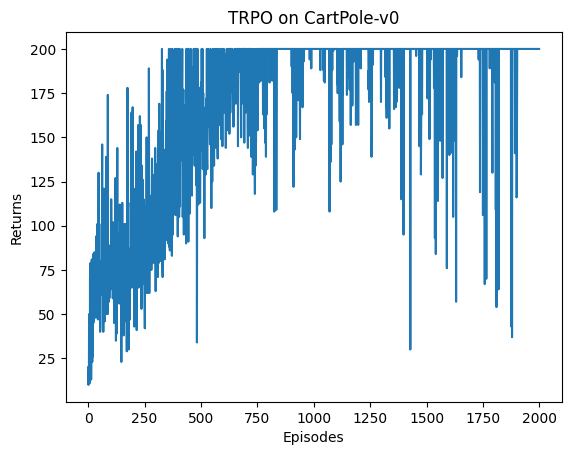

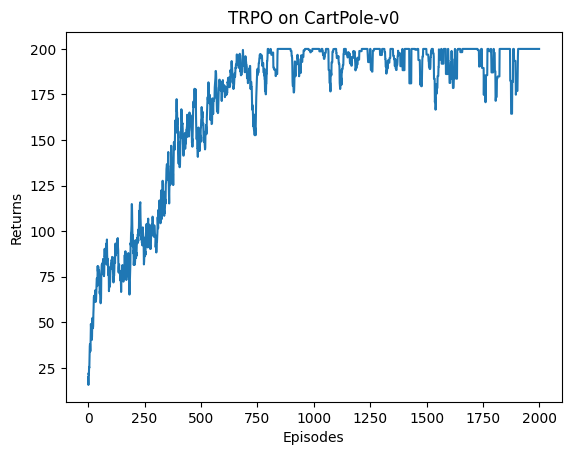

: 

In [11]:
num_episodes = 500
hidden_dim = 128
gamma = 0.98
lmbda = 0.95
critic_lr = 1e-2
kl_constraint = 0.0005
alpha = 0.5
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

env_name = 'CartPole-v0'
env = gym.make(env_name)
env.seed(0)
torch.manual_seed(0)
agent = TRPO(hidden_dim, env.observation_space, env.action_space, lmbda,
             kl_constraint, alpha, critic_lr, gamma, device)
return_list = rl_utils.train_on_policy_agent(env, agent, num_episodes)

episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('TRPO on {}'.format(env_name))
plt.show()

mv_return = rl_utils.moving_average(return_list, 9)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('TRPO on {}'.format(env_name))
plt.show()

## 2. 连续动作空间

In [5]:
class PolicyNetContinuous(nn.Module):
    def __init__(self, state_dim:int, hidden_dim:int, action_dim:int):
        super().__init__()
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, action_dim)
        self.fc_std = nn.Linear(hidden_dim, action_dim)

    def forward(self, x:torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        x = F.relu(self.fc1(x))
        mu = 2.0 * torch.tanh(self.fc_mu(x))
        std = F.softplus(self.fc_std(x))
        return mu, std  # 高斯分布的均值和标准差

In [9]:
class TRPOContinuous(rl_utils.BasePolicy):
    """ 处理连续动作的TRPO算法 """
    def __init__(self, 
            hidden_dim:int, state_space:gym.Space, action_space:gym.Space, 
            lmbda:float, kl_constraint:float, alpha:float, critic_lr:float, gamma:float, 
            device:torch.device
        ):
        state_dim = state_space.shape[0]
        action_dim = action_space.shape[0]
        self.actor = PolicyNetContinuous(state_dim, hidden_dim,
                                         action_dim).to(device)
        self.critic = ValueNet(state_dim, hidden_dim).to(device)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(),
                                                 lr=critic_lr)
        self.gamma = gamma
        self.lmbda = lmbda
        self.kl_constraint = kl_constraint
        self.alpha = alpha
        self.device = device

    def take_action(self, state:torch.Tensor) -> list[int]:
        state = torch.tensor(np.array([state]), dtype=torch.float).to(self.device)
        mu, std = self.actor(state)
        action_dist = Normal(mu, std)
        action = action_dist.sample()
        return [action.item()]

    def hessian_matrix_vector_product(self,
            states:torch.Tensor, old_action_dists:Normal, 
            vector:torch.Tensor, damping:float=0.1
        ) -> torch.Tensor:
        mu, std = self.actor(states)
        new_action_dists = Normal(mu, std)
        kl = torch.mean(kl_divergence(old_action_dists, new_action_dists))
        kl_grad = torch.autograd.grad(
                kl, self.actor.parameters(), create_graph=True
            )
        kl_grad_vector = torch.cat(
                [grad.view(-1) for grad in kl_grad]
            )
        kl_grad_vector_product = torch.dot(kl_grad_vector, vector)
        grad2 = torch.autograd.grad(
                kl_grad_vector_product, self.actor.parameters()
            )
        grad2_vector = torch.cat(
                [grad.contiguous().view(-1) for grad in grad2]
            )
        return grad2_vector + damping * vector

    def conjugate_gradient(self, 
            grad:torch.Tensor, states:torch.Tensor, old_action_dists:Normal
        ) -> torch.Tensor:
        x = torch.zeros_like(grad)
        r = grad.clone()
        p = grad.clone()
        rdotr = torch.dot(r, r)
        for i in range(10):
            Hp = self.hessian_matrix_vector_product(
                    states, old_action_dists, p
                )
            alpha = rdotr / torch.dot(p, Hp)
            x += alpha * p
            r -= alpha * Hp
            new_rdotr = torch.dot(r, r)
            if new_rdotr < 1e-10:
                break
            beta = new_rdotr / rdotr
            p = r + beta * p
            rdotr = new_rdotr
        return x

    def compute_surrogate_obj(self, 
            states:torch.Tensor, actions:torch.Tensor, advantage:torch.Tensor, 
            old_log_probs:torch.Tensor, actor:PolicyNet
        ) -> torch.Tensor:
        mu, std = actor(states)
        action_dists = Normal(mu, std)
        log_probs = action_dists.log_prob(actions)
        ratio = torch.exp(log_probs - old_log_probs)
        return torch.mean(ratio * advantage)

    def line_search(self, 
            states:torch.Tensor, actions:torch.Tensor, advantage:torch.Tensor, 
            old_log_probs:torch.Tensor, old_action_dists:Normal, 
            max_vec:torch.Tensor
        ) -> torch.Tensor:
        old_para = nn.utils.convert_parameters.parameters_to_vector(
                    self.actor.parameters()
                )
        old_obj = self.compute_surrogate_obj(
                    states, actions, advantage, old_log_probs, self.actor
                )
        for i in range(15):
            coef = self.alpha**i
            new_para = old_para + coef * max_vec
            new_actor = copy.deepcopy(self.actor)
            nn.utils.convert_parameters.vector_to_parameters(
                    new_para, new_actor.parameters()
                )
            mu, std = new_actor(states)
            new_action_dists = Normal(mu, std)
            kl_div = torch.mean(kl_divergence(old_action_dists, new_action_dists))
            new_obj = self.compute_surrogate_obj(
                        states, actions, advantage, old_log_probs, new_actor
                    )
            if new_obj > old_obj and kl_div < self.kl_constraint:
                return new_para
        return old_para

    def policy_learn(self, 
            states:torch.Tensor, actions:torch.Tensor, 
            old_action_dists:Normal, old_log_probs:torch.Tensor,
            advantage:torch.Tensor
        ):
        surrogate_obj = self.compute_surrogate_obj(
                            states, actions, advantage, old_log_probs, self.actor
                        )
        grads = torch.autograd.grad(surrogate_obj, self.actor.parameters())
        obj_grad = torch.cat([grad.view(-1) for grad in grads]).detach()
        descent_direction = self.conjugate_gradient(obj_grad, states, old_action_dists)
        Hd = self.hessian_matrix_vector_product(
                states, old_action_dists, descent_direction
            )
        max_coef = torch.sqrt(
                        2 * self.kl_constraint /
                        (torch.dot(descent_direction, Hd) + 1e-8)
                    )
        new_para = self.line_search(
                        states, actions, advantage, old_log_probs, old_action_dists,
                        descent_direction * max_coef
                    )
        nn.utils.convert_parameters.vector_to_parameters(
                new_para, self.actor.parameters()
        )

    def update(self, transition_dict:dict):
        states = torch.tensor(transition_dict['states'],
                        dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions'],
                        dtype=torch.float).view(-1, 1).to(self.device)
        rewards = torch.tensor(transition_dict['rewards'],
                        dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'],
                        dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'],
                        dtype=torch.float).view(-1, 1).to(self.device)

        # 对奖励进行修改,方便训练
        rewards = (rewards + 8.0) / 8.0  
        td_target = rewards + self.gamma * self.critic(next_states) * (1 - dones)
        td_delta = td_target - self.critic(states)
        advantage = rl_utils.compute_advantage(
                        self.gamma, self.lmbda, td_delta.cpu()
                    ).to(self.device)
        mu, std = self.actor(states)
        old_action_dists = Normal(mu.detach(), std.detach())
        old_log_probs = old_action_dists.log_prob(actions)
        critic_loss = torch.mean(
                        F.mse_loss(self.critic(states), td_target.detach())
                    )
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()
        self.policy_learn(
            states, actions, old_action_dists, old_log_probs, advantage
        )

Iteration 9: 100%|██████████| 200/200 [00:32<00:00,  6.23it/s, episode=2000, return=-452.638]


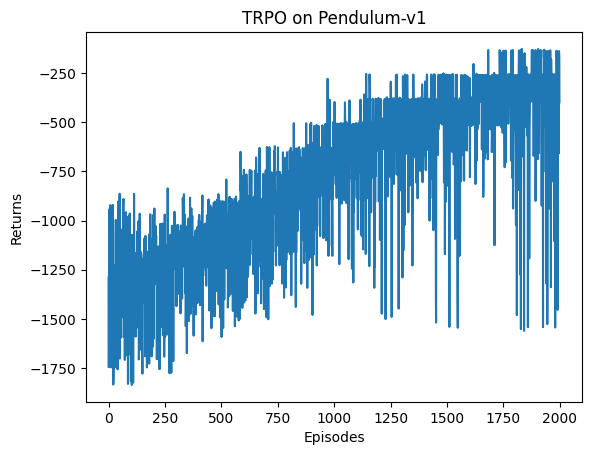

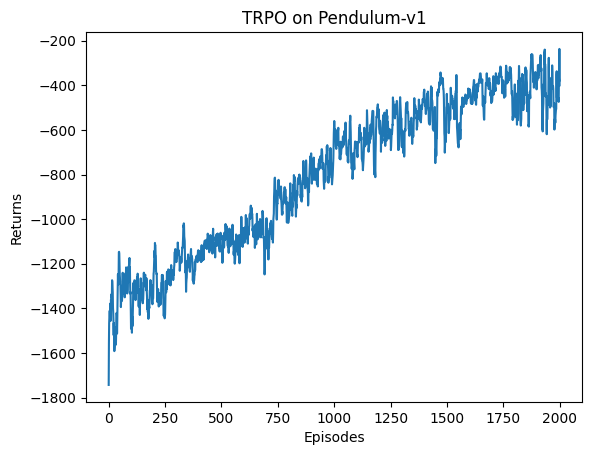

In [10]:
num_episodes = 2000
hidden_dim = 128
gamma = 0.9
lmbda = 0.9
critic_lr = 1e-2
kl_constraint = 0.00005
alpha = 0.5
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

env_name = 'Pendulum-v1'
env = gym.make(env_name)
env.seed(0)
torch.manual_seed(0)
agent = TRPOContinuous(hidden_dim, env.observation_space, env.action_space,
                       lmbda, kl_constraint, alpha, critic_lr, gamma, device)
return_list = rl_utils.train_on_policy_agent(env, agent, num_episodes)

episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('TRPO on {}'.format(env_name))
plt.show()

mv_return = rl_utils.moving_average(return_list, 9)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('TRPO on {}'.format(env_name))
plt.show()